In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [24]:
# Load the CSV files with specified encoding
user_engagement = pd.read_csv('/home/hb/Downloads/assignmentformlroletensoriot/takehome_user_engagement_1.csv', encoding='latin1')
users = pd.read_csv('/home/hb/Downloads/assignmentformlroletensoriot/takehome_users_2.csv', encoding='latin1')

In [25]:
# Convert time_stamp to datetime
user_engagement['time_stamp'] = pd.to_datetime(user_engagement['time_stamp'])

In [26]:
# Convert creation_time and last_session_creation_time to datetime
users['creation_time'] = pd.to_datetime(users['creation_time'])
users['last_session_creation_time'] = pd.to_datetime(users['last_session_creation_time'], unit='s')

In [27]:
# Merge datasets on user_id/object_id
merged_df = pd.merge(user_engagement, users, left_on='user_id', right_on='object_id')

# Check for missing values and handle them
merged_df = merged_df.dropna()

In [28]:
# Define adopted user function
def is_adopted_user(df):
    # Create a new column 'date' with only the date part of 'time_stamp'
    df['date'] = df['time_stamp'].dt.date
    
    # Sort the dataframe by 'user_id' and 'date' to ensure chronological order for each user
    df = df.sort_values(['user_id', 'date'])
    
    # Initialize an empty list to store the results
    adopted_users = []

    # Group the dataframe by 'user_id'
    for user_id, group in df.groupby('user_id'):
        # Extract unique login dates for the current user
        dates = group['date'].unique()
        # Initialize the adopted status as False
        adopted = False
        
        # Check if the user has logged in on three separate days within any seven-day period
        for i in range(len(dates) - 2):
            if (dates[i + 2] - dates[i]).days <= 7:
                adopted = True
                break
        
        # Append the user_id and adopted status to the results list
        adopted_users.append((user_id, adopted))

    # Convert the results list to a DataFrame and return it
    return pd.DataFrame(adopted_users, columns=['user_id', 'adopted'])

In [29]:
adopted_users = is_adopted_user(user_engagement)
users['adopted_user'] = users['object_id'].isin(adopted_users[adopted_users['adopted']]['user_id']).astype(int)

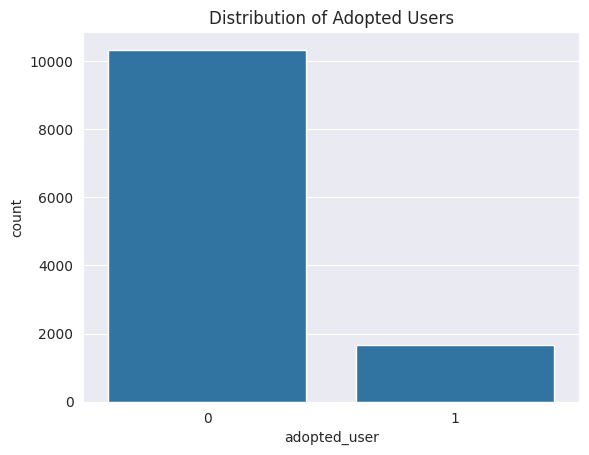

In [30]:
# Exploratory Data Analysis
sns.countplot(x='adopted_user', data=users)
plt.title('Distribution of Adopted Users')
plt.show()

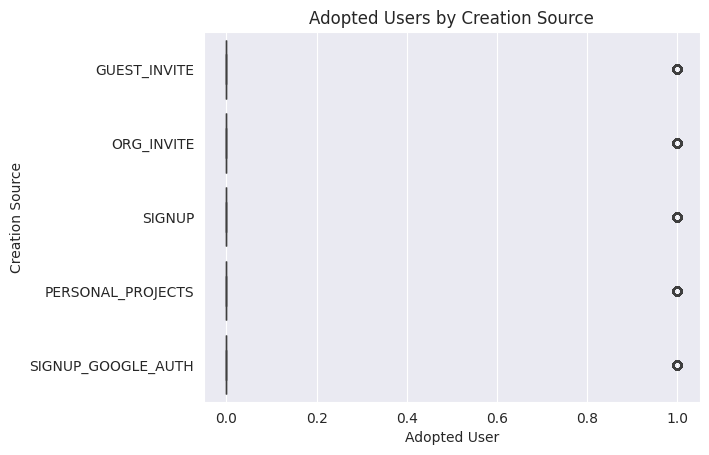

In [31]:
sns.boxplot(x='adopted_user', y='creation_source', data=users)
plt.title('Adopted Users by Creation Source')
plt.xlabel('Adopted User')
plt.ylabel('Creation Source')
plt.show()

A count plot displays the impact of opting into the mailing list on adoption rates.


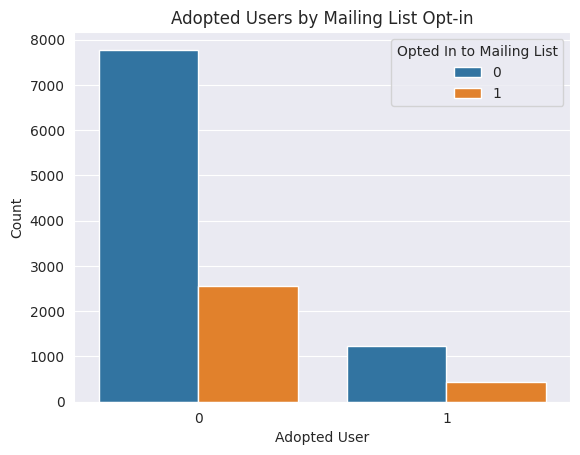

In [32]:
sns.countplot(x='adopted_user', hue='opted_in_to_mailing_list', data=users)
plt.title('Adopted Users by Mailing List Opt-in')
print("A count plot displays the impact of opting into the mailing list on adoption rates.")
plt.xlabel('Adopted User')
plt.ylabel('Count')
plt.legend(title='Opted In to Mailing List')
plt.show()

In [33]:
# Prepare the feature matrix and target vector
features = ['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id']
X = pd.get_dummies(users[features], drop_first=True)
y = users['adopted_user']

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
# Evaluate the model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      2063
           1       0.15      0.07      0.10       337

    accuracy                           0.81      2400
   macro avg       0.51      0.50      0.50      2400
weighted avg       0.76      0.81      0.78      2400

[[1922  141]
 [ 312   25]]


A bar plot ranks the importance of each feature in predicting user adoption according to the RandomForestClassifier model.


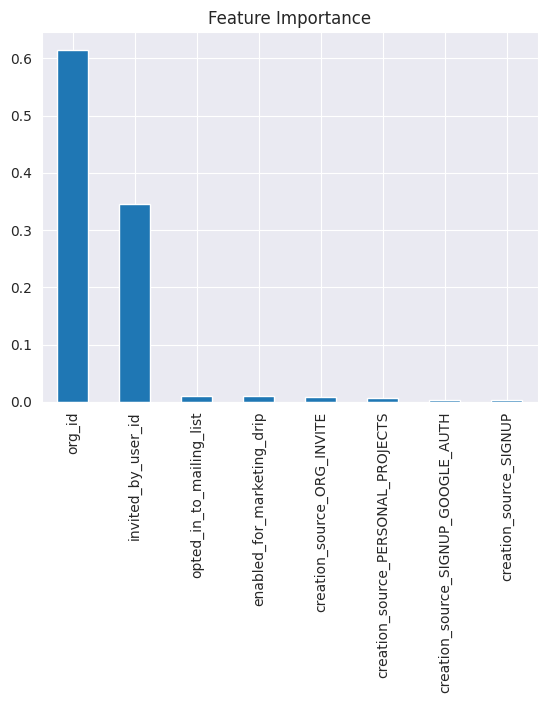

In [37]:
# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance.plot(kind='bar')
print("A bar plot ranks the importance of each feature in predicting user adoption according to the RandomForestClassifier model.")
plt.title('Feature Importance')
plt.show()